# Analysis AC thresholds (best ear)

19-01-2021 Guido Cattani, Review 31-10-2022

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from scipy.stats import mannwhitneyu as mannwhitneyu
from scipy.stats import shapiro as shapiro

In [2]:
def read_AC_thresholds():
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Headband/AC_thresholds.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, sheet_name=0, header=0, nrows=85)
    df = df.drop(['Unnamed: 0'], axis=1)
    type_dict = {'Study_ID': 'str', 'Device': 'str',
             'AC_125':'float32', 'AC_250':'float32', 'AC_500':'float32', 
             'AC_1000': 'float32', 'AC_2000': 'float32', 
             'AC_4000': 'float32', 'AC_8000': 'float32'}
    df = df.astype(type_dict)
    new_names = {
             'AC_125':'AC_125_Hz', 'AC_250':'AC_250_Hz', 'AC_500':'AC_500_Hz', 
             'AC_1000': 'AC_1000_Hz', 'AC_2000': 'AC_2000_Hz', 
             'AC_4000': 'AC_4000_Hz', 'AC_8000': 'AC_8000_Hz'}
    df.rename(mapper=new_names, axis=1, inplace=True) 
    df = df.fillna(pd.NA)
    return df

In [3]:
def present_AC_thresholds():
    ac = read_AC_thresholds()
    ac1 = ac[['Device', 'AC_500_Hz', 'AC_1000_Hz', 'AC_2000_Hz', 'AC_4000_Hz']].copy()
    ac1 = ac1.dropna()
    pta = ac1.iloc[:, 1:].mean(axis='columns')
    ac1.insert(5, column= 'PTA (0.5-4 kHz)', value=pta)
    pta_hf = ac1.iloc[:, 2:].mean(axis='columns')
    ac1.insert(6, column= 'PTA_HF (1-4 kHz)', value=pta_hf)
    return ac1

In [4]:
def select_bp110(df):
    # select BP110 data
    is_bp110 =  df['Device']=='BP110'
    df_bp110 = df[is_bp110]
    df_bp110.pop('Device')
    return(df_bp110)

In [5]:
def select_bh5(df):
    # select BAHA5P data
    is_baha5p =  df['Device']=='BAHA5P'
    df_baha5p = df[is_baha5p]
    df_baha5p.pop('Device')
    return(df_baha5p)

In [6]:
act = present_AC_thresholds()

In [7]:
act

,Device,AC_500_Hz,AC_1000_Hz,AC_2000_Hz,AC_4000_Hz,PTA (0.5-4 kHz),PTA_HF (1-4 kHz)
0,BP110,10.0,10.0,10.0,0.0,7.50,6.8750
1,BP110,10.0,10.0,15.0,65.0,25.00,28.7500
2,BP110,25.0,15.0,10.0,30.0,20.00,18.7500
3,BP110,5.0,5.0,20.0,45.0,18.75,22.1875
4,BP110,0.0,5.0,5.0,15.0,6.25,7.8125
...,...,...,...,...,...,...,...
80,BAHA5P,5.0,10.0,10.0,25.0,12.50,14.3750
81,BAHA5P,20.0,25.0,10.0,15.0,17.50,16.8750
82,BAHA5P,5.0,5.0,15.0,15.0,10.00,11.2500
83,BAHA5P,30.0,25.0,20.0,50.0,31.25,31.5625


In [8]:
# group data by device type and perform calculation of quantiles 10, 50, 90
dvc = act.groupby('Device')
quantiles = [0.10, 0.50, 0.90]
q = dvc.quantile(q=quantiles)
q = q.reset_index()
q = q.drop(['Device', 'level_1'], axis=1)
diq = {0:'BAHA5P, P10', 1:'BAHA5P, P50', 2:'BAHA5P, P90', 
       3:'BP110, P10', 4:'BP110, P50', 5:'BP110, P90'} 
q = q.rename(index=diq)
q = q.reindex(['BP110, P10', 'BP110, P50', 'BP110, P90', 
           'BAHA5P, P10', 'BAHA5P, P50', 'BAHA5P, P90'])

In [9]:
# AC thresholds filtered by device
act_bh5 = select_bh5(act)
act_bp110 = select_bp110(act)
len(act_bp110), len(act_bh5)

(49, 36)

In [10]:
# check normality AC thresholds group BAHA5P & BP110 with Shapiro-Wilk test

shp = dict()
f = ['AC_500_Hz', 'AC_1000_Hz', 'AC_2000_Hz', 'AC_4000_Hz', 'PTA (0.5-4 kHz)', 'PTA_HF (1-4 kHz)']

for i in range(6):
    a = act_bh5.iloc[:, i]
    b = act_bp110.iloc[:, i]
    shapiro_stat_bh5, pVal_bh5 = shapiro(a) # bh5 scipy.stats Shapiro-Wilk test test
    shapiro_stat_bp110, pVal_bp110 = shapiro(b) # bp110 scipy.stats Shapiro-Wilk test test
    bh5_is_normal = False if pVal_bh5 < 0.05 else True
    bp110_is_normal = False if pVal_bp110 < 0.05 else True
    both_is_normal = True if bh5_is_normal and bp110_is_normal else False
    st = {f[i]: [shapiro_stat_bh5, pVal_bh5, bh5_is_normal, shapiro_stat_bp110, pVal_bp110, bp110_is_normal, both_is_normal]}
    shp.update(st)

shapiro_test = pd.DataFrame.from_dict(shp)
dish =  {0: 'Shapiro test statistic BH5', 1: 'p-value BH5', 2: 'normally distributed in BH5', 3: 'Shapiro test statistic BP110', 
         4: 'p-value BP110', 5: 'normally distributed in BP110', 6: 'normally distributed in both groups'}
shapiro_test = shapiro_test.rename(index=dish)
shapiro_test

,AC_500_Hz,AC_1000_Hz,AC_2000_Hz,AC_4000_Hz,PTA (0.5-4 kHz),PTA_HF (1-4 kHz)
Shapiro test statistic BH5,0.909645,0.946491,0.881853,0.869089,0.923673,0.893437
p-value BH5,0.006329,0.081099,0.001129,0.000541,0.01616,0.002268
normally distributed in BH5,False,True,False,False,False,False
Shapiro test statistic BP110,0.886325,0.892675,0.93316,0.945443,0.975218,0.973589
p-value BP110,0.000202,0.000319,0.008069,0.024234,0.385007,0.334346
normally distributed in BP110,False,False,False,False,True,True
normally distributed in both groups,False,False,False,False,False,False


In [11]:
# compare distribution thresholds group BAHA5P vs. BP110 with Mann Whitney U test

mwu = dict()
f = ['AC_500_Hz', 'AC_1000_Hz', 'AC_2000_Hz', 'AC_4000_Hz', 'PTA (0.5-4 kHz)', 'PTA_HF (1-4 kHz)']

for i in range(6):
    a = act_bh5.iloc[:, i]
    b = act_bp110.iloc[:, i]
    u_statistic, pVal = mannwhitneyu(a , b, use_continuity=False, alternative='two-sided') # scipy.stats mannwhitneyu test
    pVal = round(pVal, 15)
    st = {f[i]: [u_statistic, pVal]}
    mwu.update(st)

u_test = pd.DataFrame.from_dict(mwu, dtype='float')
diu =  {0: 'Mann-Whitney U statistic', 1: 'p-value (two-sided)'}
u_test = u_test.rename(index=diu)

In [12]:
# make new dataFrame with percentiles & test results
analysis_ac = pd.concat([q, shapiro_test, u_test])
analysis_ac = analysis_ac.round(decimals=3)
analysis_ac

,AC_500_Hz,AC_1000_Hz,AC_2000_Hz,AC_4000_Hz,PTA (0.5-4 kHz),PTA_HF (1-4 kHz)
"BP110, P10",5.0,5.0,5.0,10.0,7.5,6.875
"BP110, P50",10.0,10.0,10.0,25.0,16.25,17.1875
"BP110, P90",25.0,20.0,25.0,55.0,25.0,27.625
"BAHA5P, P10",5.0,0.0,5.0,7.5,6.25,6.5625
"BAHA5P, P50",10.0,10.0,10.0,20.0,12.5,13.125
"BAHA5P, P90",20.0,20.0,20.0,42.5,23.75,25.9375
Shapiro test statistic BH5,0.909645,0.946491,0.881853,0.869089,0.923673,0.893437
p-value BH5,0.006329,0.081099,0.001129,0.000541,0.01616,0.002268
normally distributed in BH5,False,True,False,False,False,False
Shapiro test statistic BP110,0.886325,0.892675,0.93316,0.945443,0.975218,0.973589


In [13]:
# write to xlsx file
analysis_ac.to_excel("/media/guido/LACIE/Cingle_Guido/Project_band/Analysis_results/analysis_AC_thresholds.xlsx",
                         sheet_name='AC_thresholds')

In [14]:
bp110_thr = act_bp110.iloc[ : , :4]
bh5_thr = act_bh5.iloc[ : , :4]

In [15]:
# convert Pandas object in numpy array
frqc = np. array([500, 1000, 2000, 4000] , dtype=int)

bp110 = bp110_thr.T.to_numpy()
bh5 = bh5_thr.T.to_numpy()

p10_bp110 = q.iloc[0, :4].T.to_numpy()
median_bp110 = q.iloc[1, :4].T.to_numpy()
p90_bp110 = q.iloc[2, :4].T.to_numpy()
p10_bh5 = q.iloc[3, :4].T.to_numpy()
median_bh5 = q.iloc[4, :4].T.to_numpy()
p90_bh5 = q.iloc[5, :4].T.to_numpy()

[]

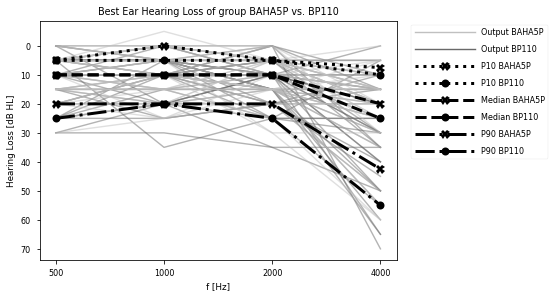

In [16]:
# matplotlib line graph of output BAHA5P vs. BP110 

plt.style.use('seaborn-paper')

fig, ax = plt.subplots()

ax.set(xlabel='f [Hz]', ylabel='Hearing Loss [dB HL]',
       title='Best Ear Hearing Loss of group BAHA5P vs. BP110')

ax.set_xscale('log')
ax.set_xticks([500, 1000, 2000, 4000])
ax.set_xticklabels(['500', '1000', '2000', '4000'])
ax.minorticks_off()
ax.invert_yaxis()

# plot lines based on numpy arrays
ax.plot(frqc, bp110, color="dimgrey", alpha=0.5, label='Output FL BP110')
ax.plot(frqc, bh5, color="silver", alpha=0.5, label='Output FL BAHA5P')
ax.plot(frqc, median_bp110, color='black', marker='o', linestyle='dashed', linewidth=3, markersize=8)
ax.plot(frqc, p10_bp110, color='black', marker='o', linestyle='dotted', linewidth=3, markersize=8)
ax.plot(frqc, p90_bp110, color='black', marker='o', linestyle='dashdot', linewidth=3, markersize=8)
ax.plot(frqc, median_bh5, color='black', marker='X', linestyle='dashed', linewidth=3, markersize=9)
ax.plot(frqc, p10_bh5, color='black', marker='X', linestyle='dotted', linewidth=3, markersize=9)
ax.plot(frqc, p90_bh5, color='black', marker='X', linestyle='dashdot', linewidth=3, markersize=9)

# make a legend
leg_line_BH5 = mlines.Line2D([], [], color="silver", label='Output BAHA5P')
leg_line_BP110 = mlines.Line2D([], [], color="dimgrey", label='Output BP110')
leg_p90_bh5 = mlines.Line2D([], [], color='black', marker='X', linestyle='dashdot', 
                            linewidth=3, markersize=9, label='P90 BAHA5P')
leg_med_bh5 = mlines.Line2D([], [], color='black', marker='X', linestyle='dashed', 
                            linewidth=3, markersize=9, label='Median BAHA5P')
leg_p10_bh5 = mlines.Line2D([], [], color='black', marker='X', linestyle='dotted', 
                            linewidth=3, markersize=9, label='P10 BAHA5P')
leg_p90_bp110 = mlines.Line2D([], [], color='black', marker='o', linestyle='dashdot', 
                              linewidth=3, markersize=8, label='P90 BP110')
leg_med_bp110 = mlines.Line2D([], [], color='black', marker='o', linestyle='dashed', 
                              linewidth=3, markersize=8, label='Median BP110')
leg_p10_bp110 = mlines.Line2D([], [], color='black', marker='o', linestyle='dotted', 
                              linewidth=3, markersize=8, label='P10 BP110')

plt.legend(handles=[leg_line_BH5, leg_line_BP110, leg_p10_bh5, leg_p10_bp110, leg_med_bh5, 
                    leg_med_bp110, leg_p90_bh5, leg_p90_bp110], bbox_to_anchor=(1.03, 1), 
                        loc='upper left', labelspacing=1.,handlelength=7.5)

# save the figure
plt.savefig('/media/guido/LACIE/Cingle_Guido/Project_band/Analysis_results/AC_thresholds.tiff', 
            transparent=False, dpi=500, bbox_inches="tight")

# plot the figure
plt.plot()